# Metallicity Profiles

In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import json
from scipy.stats import binned_statistic
from scipy.stats import linregress
from scipy.optimize import curve_fit
from itertools import product

In [2]:
from auriga.snapshot import Snapshot
from auriga.images import figure_setup, set_axs_configuration
from auriga.settings import Settings
from auriga.parser import parse
from auriga.physics import Physics
from auriga.mathematics import linear

In [3]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(
    color=list(mcolors.TABLEAU_COLORS.values()))

In [5]:
figure_setup()
settings = Settings()

In [7]:
RXY_RANGE: tuple = (0, 30)
N_BINS: int = 30

In [8]:
def read_snapshot_data(simulation: str, of: str,
                       to: str, band: str = None) -> tuple:
    """
    This method returns data of interest for this analysis.

    Parameters
    ----------
    simulation : str
        The simulation to consider.
    of : str
        The metal of which to calculate the metallicity.
    to : str
        The metal to which to calculate the metallicity.
    band : str, optional
        The optical band for the luminosity calculation. If band is not
        provided, luminosities will not be added to the data.

    Returns
    -------
    pd.DataFrame
        A data frame with the properties.
    """

    settings = Settings()

    s = Snapshot(simulation=simulation, loadonlytype=[4])
    s.add_extra_coordinates()
    s.add_metal_abundance(of=of, to=to)
    s.add_stellar_age()
    s.add_stellar_photometrics()

    is_real_star = (s.type == 4) & (s.stellar_formation_time > 0)
    is_main_obj = (s.halo == s.halo_idx) & (s.subhalo == s.subhalo_idx)

    df = pd.DataFrame()
    df[f"[{of}/{to}]_dex"] = s.metal_abundance[f"{of}/{to}"][
        is_real_star & is_main_obj]
    df["CylindricalRadius_ckpc"] = s.rho[is_real_star & is_main_obj]
    df["StellarAge_Gyr"] = s.stellar_age[is_real_star & is_main_obj]

    if band is not None:  # Load luminosities if a band was provided
        s.add_luminosities(band=band)
        df["Luminosity_W"] = s.stellar_luminosities[is_real_star & is_main_obj]

    # Remove invalid data
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    return df

In [9]:
def calc_mean_stat(x, y, n_bins: int, xrange: tuple, weights = None):
    if weights is None: weights = np.ones(x.shape)

    num = binned_statistic(x=x, values=y * weights,
        statistic="sum", bins=n_bins, range=xrange)[0]
    den = binned_statistic(x=x, values=weights,
        statistic="sum", bins=n_bins, range=xrange)[0]
    mean = num / den

    std, bin_edges, _ = binned_statistic(
        x=x, values=y, statistic="std", bins=n_bins, range=xrange)
    count, _, _ = binned_statistic(
        x=x, values=y, statistic="count", bins=n_bins, range=xrange)
    err = std / np.sqrt(count)

    bin_centers = bin_edges[1:] - np.diff(bin_edges)[0] / 2
    return bin_centers, mean, err

In [10]:
def read_sample_data(galaxies: list, band: str = None) -> pd.DataFrame:
    df = pd.DataFrame()
    for galaxy in galaxies:
        gdf = read_snapshot_data(
            simulation=galaxy, of="Fe", to='H', band=band)
        if band is not None:  # Set weights for binned data
            weights = gdf["Luminosity_W"]
        else:
            weights = np.ones(len(gdf))
        bin_centers, mean, _ = calc_mean_stat(
            x=gdf["CylindricalRadius_ckpc"], y=gdf["[Fe/H]_dex"],
            weights=weights, n_bins=N_BINS, xrange=RXY_RANGE)
        df[f"{galaxy.upper()}_<[Fe/H]>_dex"] = mean
    df["BinCenters_ckpc"] = bin_centers
    return df

## [Fe/H] Profiles

### Au6

In [98]:
galaxy = "au6_or_l4_s127"

In [99]:
df = read_sample_data(galaxies=[galaxy])
df = df.rename(columns={f"{galaxy.upper()}_<[Fe/H]>_dex": "<[Fe/H]>_dex"})

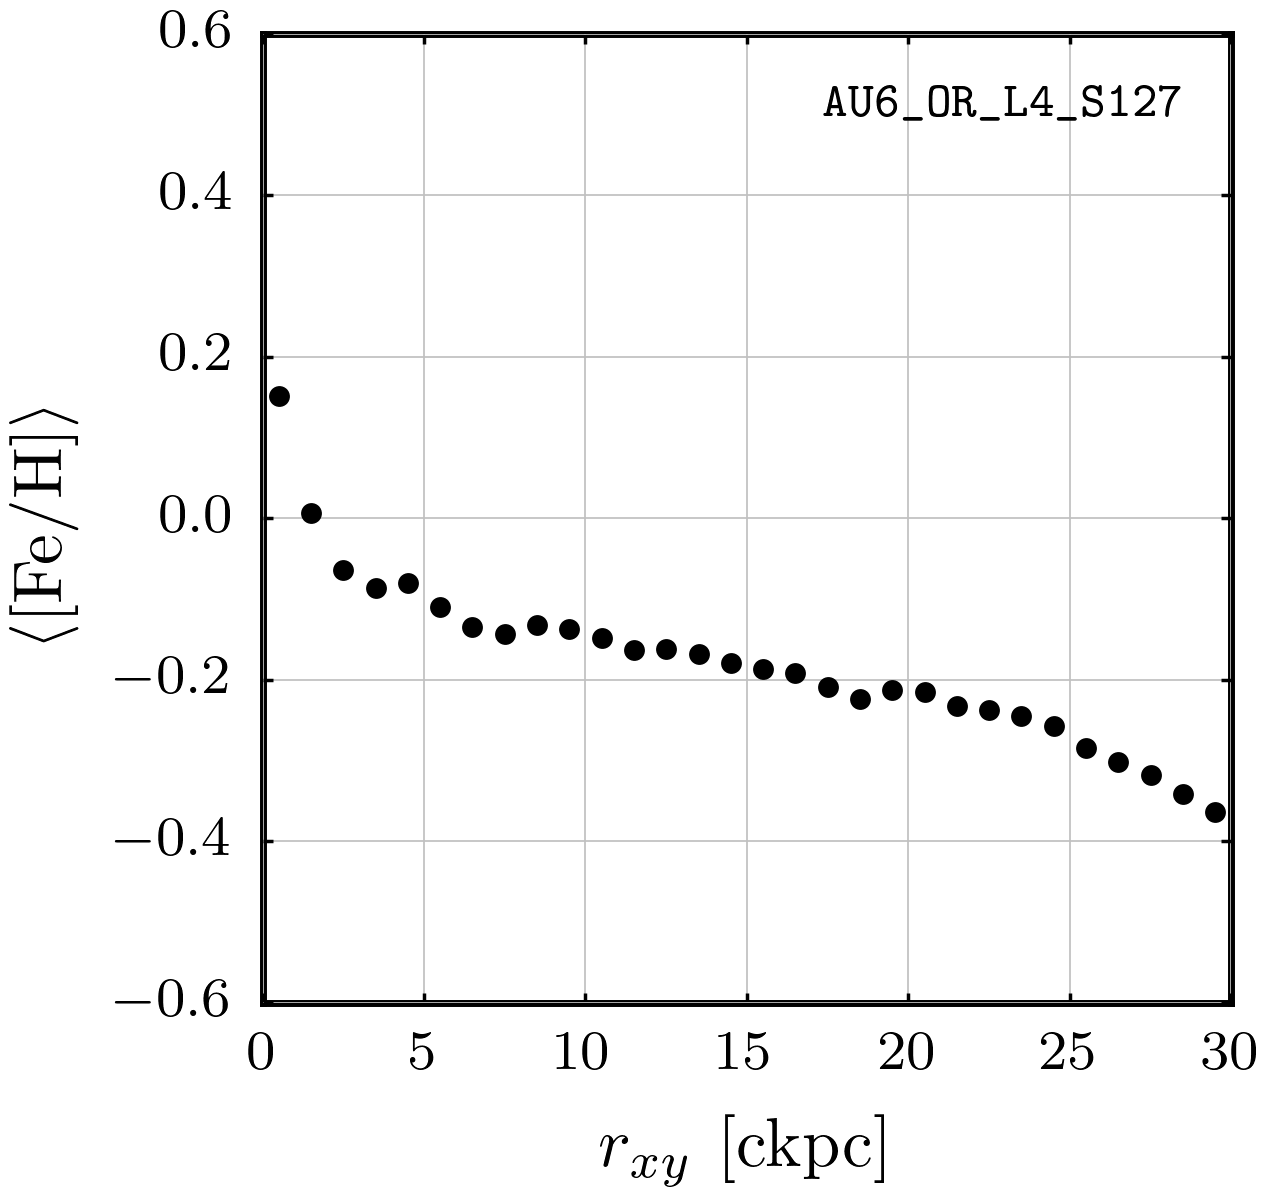

In [100]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.set_xlim(0, 30)
ax.set_ylim(-0.6, 0.6)
ax.set_xlabel(r"$r_{xy}$ [ckpc]")
ax.set_ylabel(r"$\left< \mathrm{[Fe/H]} \right>$")

ax.grid(True, ls='-', lw=0.25, c='silver')

ax.plot(df["BinCenters_ckpc"], df["<[Fe/H]>_dex"],
        markersize=3, marker='o', lw=0,
        markeredgewidth=0, markerfacecolor='k', color='k', zorder=10)

ax.text(
    x=0.95, y=0.95, size=7.0,
    s=r"$\texttt{" + galaxy.upper() + "}$",
    ha="right", va="top", transform=ax.transAxes)

plt.show()

### Sample + Average

In [11]:
sample = [f"au{i}_or_l4_s127" for i in settings.galaxies]
df = read_sample_data(galaxies=sample)

In [19]:
df["SampleAverage_<[Fe/H]>_dex"] = df[
    [f"{galaxy.upper()}_<[Fe/H]>_dex" for galaxy in sample]].mean(axis=1)
df["SampleDispersion_<[Fe/H]>_dex"] = df[
    [f"{galaxy.upper()}_<[Fe/H]>_dex" for galaxy in sample]].std(axis=1)

In [102]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.set_xlim(0, 30)
ax.set_ylim(-0.6, 0.6)
ax.set_xlabel(r"$r_{xy}$ [ckpc]")
ax.set_ylabel(r"$\left< \mathrm{[Fe/H]} \right>$")

ax.grid(True, ls='-', lw=0.25, c='silver')

for galaxy in sample:
    ax.plot(df["BinCenters_ckpc"], df[f"{galaxy.upper()}_<[Fe/H]>_dex"],
            lw=1, color="gainsboro", zorder=10)

ax.plot(df["BinCenters_ckpc"], df["SampleAverage_<[Fe/H]>_dex"],
        lw=1, color='k', zorder=11)
ax.plot(df["BinCenters_ckpc"],
        df["SampleAverage_<[Fe/H]>_dex"] - df["SampleDispersion_<[Fe/H]>_dex"],
        lw=1, color='k', zorder=11, ls="--")
ax.plot(df["BinCenters_ckpc"],
        df["SampleAverage_<[Fe/H]>_dex"] + df["SampleDispersion_<[Fe/H]>_dex"],
        lw=1, color='k', zorder=11, ls="--")

fig.savefig(
    f"../images/metallicity_profiles/originals_average_total.pdf")
plt.close(fig)

### Gradient Comparison

#### Optimal Range

In [103]:
displace = [i for i in range(16)]
possible_combinations = list(product(displace, [30 - i for i in displace]))
combinations = []
for i in range(len(possible_combinations)):
    if np.abs(possible_combinations[i][0] - possible_combinations[i][1]) >= 5:
        combinations.append(possible_combinations[i])

In [104]:
# Find optimal fit range for each galaxy
optimal_fits = []
for galaxy in sample:
    x = df["BinCenters_ckpc"].to_numpy()
    y = df[f"{galaxy.upper()}_<[Fe/H]>_dex"].to_numpy()
    optimal_fit = None
    best_chi2 = None
    for combination in combinations:
        x_range = x[(x > combination[0]) & (x < combination[1])]
        y_range = y[(x > combination[0]) & (x < combination[1])]
        y_err = np.ones_like(x_range)
        regress = linregress(x=x_range, y=y_range)
        chi2 = np.sum(
            ((y_range \
              - x_range * regress.slope + regress.intercept)) / y_err)**2
        chi2 /= (len(x) - 2)  # Normalize the chi2
        if optimal_fit is None:
            optimal_fit = regress
            best_chi2 = chi2
        elif np.abs(chi2 - 1) < np.abs(best_chi2 - 1):
            optimal_fit = regress
            best_chi2 = chi2
    optimal_fits.append(optimal_fit)

In [105]:
# Find optimal fit range for the sample average
x = df["BinCenters_ckpc"].to_numpy()
y = df[f"SampleAverage_<[Fe/H]>_dex"].to_numpy()
sample_optimal_fit = None
best_chi2 = None
for combination in combinations:
    x_range = x[(x > combination[0]) & (x < combination[1])]
    y_range = y[(x > combination[0]) & (x < combination[1])]
    y_err = np.ones_like(x_range)
    regress = linregress(x=x_range, y=y_range)
    chi2 = np.sum(
        ((y_range \
            - x_range * regress.slope + regress.intercept)) / y_err)**2
    chi2 /= (len(x) - 2)  # Normalize the chi2
    if sample_optimal_fit is None:
        sample_optimal_fit = regress
        best_chi2 = chi2
    elif np.abs(chi2 - 1) < np.abs(best_chi2 - 1):
        sample_optimal_fit = regress
        best_chi2 = chi2

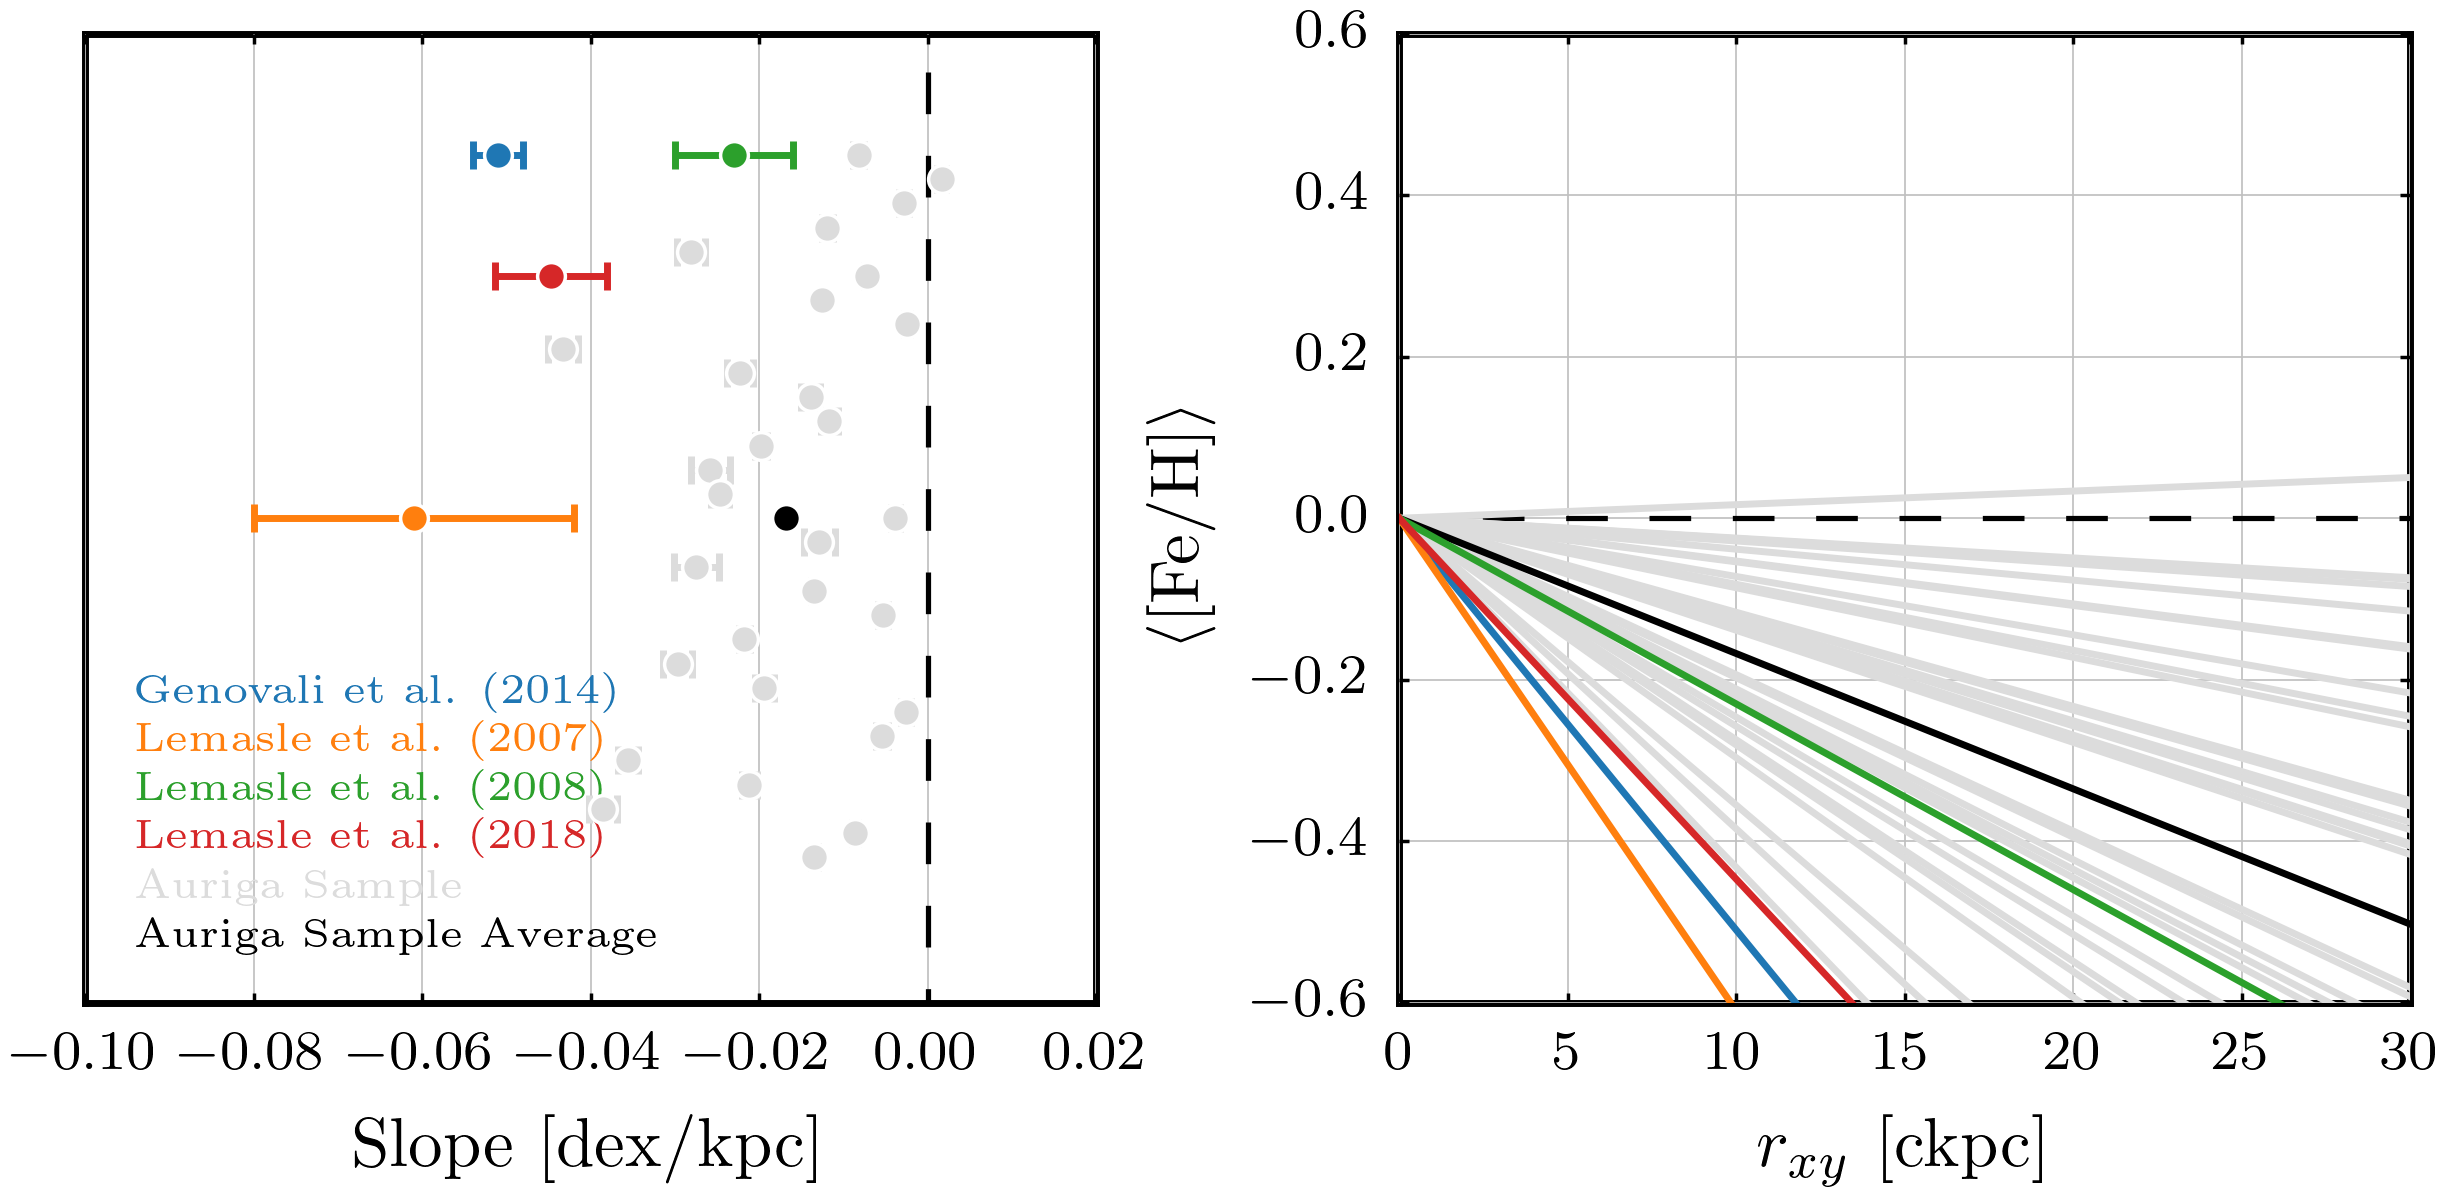

In [106]:
fig, axs = plt.subplots(figsize=(6.0, 2.5), ncols=2,
                        gridspec_kw={"wspace": 0.3})

axs[0].set_xlim(-0.1, 0.02)
axs[0].set_ylim(-0.35, 0.05)
axs[0].set_xlabel(r"Slope [dex/kpc]")
axs[0].set_yticks([])

axs[1].set_xlim(0, 30)
axs[1].set_ylim(-0.6, 0.6)
axs[1].set_xlabel(r"$r_{xy}$ [ckpc]")
axs[1].set_ylabel(r"$\left< \mathrm{[Fe/H]} \right>$")

for ax in axs:
    ax.grid(True, ls='-', lw=0.25, c='silver')

for i, fit in enumerate(optimal_fits):
    axs[0].errorbar(
        fit.slope, 0 - 0.01 * i,
        xerr=fit.stderr, color="gainsboro",
        markeredgecolor="white", capsize=2, capthick=1,
        marker='o', markersize=4, linestyle='none', zorder=10)

axs[0].errorbar(
    sample_optimal_fit.slope, -0.15, xerr=sample_optimal_fit.stderr,
    markeredgecolor="white", capsize=2, capthick=1, color='k',
    marker='o', markersize=4, linestyle='none', zorder=10)

axs[0].errorbar(
    data1["Data"]["Slope"], 0, xerr=data1["Data"]["SlopeErr"],
    markeredgecolor="white", capsize=2, capthick=1,
    marker='o', markersize=4, linestyle='none', zorder=10)
axs[0].errorbar(
    data2["Data"]["Slope"], -0.15, xerr=data2["Data"]["SlopeErr"],
    markeredgecolor="white", capsize=2, capthick=1,
    marker='o', markersize=4, linestyle='none', zorder=10)
axs[0].errorbar(
    data3["Data"]["Slope"], 0, xerr=data3["Data"]["SlopeErr"],
    markeredgecolor="white", capsize=2, capthick=1,
    marker='o', markersize=4, linestyle='none', zorder=10)
axs[0].errorbar(
    data4["Data"]["BootstrapSlope"], -0.05,
    xerr=data4["Data"]["BootstrapSlopeErr"],
    markeredgecolor="white", capsize=2, capthick=1,
    marker='o', markersize=4, linestyle='none', zorder=10)

axs[0].plot([0] * 2, ax.get_ylim(), ls="--", lw=0.75, color='k', zorder=10)

axs[0].text(
    x=0.05, y=0.30, size=6.0, color="tab:blue", ha="left", va="bottom",
    s="Genovali et al. (2014)", transform=axs[0].transAxes)
axs[0].text(
    x=0.05, y=0.25, size=6.0, color="tab:orange", ha="left", va="bottom",
    s="Lemasle et al. (2007)", transform=axs[0].transAxes)
axs[0].text(
    x=0.05, y=0.20, size=6.0, color="tab:green", ha="left", va="bottom",
    s="Lemasle et al. (2008)", transform=axs[0].transAxes)
axs[0].text(
    x=0.05, y=0.15, size=6.0, color="tab:red", ha="left", va="bottom",
    s="Lemasle et al. (2018)", transform=axs[0].transAxes)
axs[0].text(
    x=0.05, y=0.1, size=6.0, color="gainsboro", ha="left", va="bottom",
    s="Auriga Sample", transform=axs[0].transAxes)
axs[0].text(
    x=0.05, y=0.05, size=6.0, color='k', ha="left", va="bottom",
    s="Auriga Sample Average", transform=axs[0].transAxes)

axs[1].plot(axs[1].get_xlim(), [0] * 2, ls="--", lw=0.75, color='k', zorder=10)
x = np.linspace(0, 30, 100)
for fit in optimal_fits:
    axs[1].plot(x, x * fit.slope, color="gainsboro",lw=1, zorder=10)
axs[1].plot(x, x * sample_optimal_fit.slope, color='k', lw=1, zorder=11)
axs[1].plot(x, x * data1["Data"]["Slope"], lw=1, zorder=11)
axs[1].plot(x, x * data2["Data"]["Slope"], lw=1, zorder=11)
axs[1].plot(x, x * data3["Data"]["Slope"], lw=1, zorder=11)
axs[1].plot(x, x * data4["Data"]["BootstrapSlope"], lw=1, zorder=11)

plt.show()

#### Data Range

In [12]:
data1 = json.load(open("../data/genovali_2014.json"))
data2 = json.load(open("../data/lemasle_2007.json"))
data3 = json.load(open("../data/lemasle_2008.json"))
data4 = json.load(open("../data/lemasle_2018.json"))

In [15]:
print(data1["Notes"],  # 4 - 15 kpc
    data2["Notes"],  # 8 - 12 kpc
    data3["Notes"],  # 8 - 15 kpc
    data4["Notes"],  # 6 - 14 kpc
    sep="\n")
fit_range = (4, 15)

The current data set covers a range in Galactocentric distances of more than 10 kpc (4 <= RG <= 15 kpc). We estimated the metallicity gradient (dashed line) and we found [Fe/H] = 0.49 +/- 0.03 − 0.051 +/- 0.003 RG / kpc. The new slope and zero-point agree quite well with similar estimates available in the literature (Luck & Lambert 2011; Lemasle et al. 2013).
Data plotted in the top panel of Fig. 7 show that the slope is –0.061 dex/kpc in the region ranging from ~8 to ~12 kpc.
The 63 stars of this sample are located between 8 and 15 kpc from the Galactic center (see Fig. 3). We investigated at first the working hypothesis of a linear gradient and calculated the iron Galactic gradient using the entire Cepheid sample. We found a slope of –0.023 +/- 0.007 dex/kpc that is shallower than previous studies.
With the bootstrap method, we obtain a slope of −0.0447 +/- 0.0066 dex/kpc for the gradient (see Fig. 6). [...] The agreement remains reasonable with the total least squares method (Fig. 8

In [16]:
# Fit sample in the range
range_fits = []
for galaxy in sample:
    x = df["BinCenters_ckpc"].to_numpy()
    y = df[f"{galaxy.upper()}_<[Fe/H]>_dex"].to_numpy()
    x_range = x[(x > fit_range[0]) & (x < fit_range[1])]
    y_range = y[(x > fit_range[0]) & (x < fit_range[1])]
    regress = linregress(x=x_range, y=y_range)
    range_fits.append(regress)

In [21]:
# Fit of the sample average
x = df["BinCenters_ckpc"].to_numpy()
y = df[f"SampleAverage_<[Fe/H]>_dex"].to_numpy()

x_range = x[(x > fit_range[0]) & (x < fit_range[1])]
y_range = y[(x > fit_range[0]) & (x < fit_range[1])]
sample_fit = linregress(x=x_range, y=y_range)

In [39]:
y_data[-1] - y_delta

-0.6

In [42]:
y_delta = 0.02

y_data = [0]
x_data = [sample_fit.slope]
x_data_err = [sample_fit.stderr]
y_label = [r"\textbf{Auriga}"]
c = ['k']

for i, fit in enumerate(range_fits):
    y_data.append(- y_delta * i)
    x_data.append(fit.slope)
    x_data_err.append(fit.stderr)
    y_label.append(f"Au{i + 1}")
    c.append("gainsboro")

In [ ]:
fig, axs = plt.subplots(figsize=(7.2, 4.0), ncols=2,
                       gridspec_kw={"wspace": 0.3})

axs[0].set_xlim(-0.1, 0.02)
axs[0].set_ylim(-0.7, 0.02)
axs[0].set_xlabel(r"Slope [dex/kpc]")
axs[0].set_yticks([- i * 0.02 for i in range(35)])
axs[0].set_yticklabels([])

axs[1].set_xlim(0, 30)
axs[1].set_ylim(-0.6, 0.6)
axs[1].set_xlabel(r"$r_{xy}$ [ckpc]")
axs[1].set_ylabel(r"$\left< \mathrm{[Fe/H]} \right>$")

for ax in axs: ax.grid(True, ls='-', lw=0.25, c='gainsboro')

axs[0].errorbar(
    sample_fit.slope, 0, xerr=sample_fit.stderr,
    markeredgecolor="white", capsize=2, capthick=1, color='k',
    marker='o', markersize=4, linestyle='none', zorder=10)

for i, fit in enumerate(range_fits):
    axs[0].errorbar(
        fit.slope, 0 - 0.02 * (i + 1),
        xerr=fit.stderr, color="gray",
        markeredgecolor="white", capsize=2, capthick=1,
        marker='o', markersize=4, linestyle='none', zorder=10)
    axs[0].text(
        x=-0.105, y=0 - 0.02 * (i + 1), size=6.0, color="gray",
        ha="right", va="center", s=f"Au{i + 1}")

axs[0].errorbar(
    data1["Data"]["Slope"], - 0.02 * 31, xerr=data1["Data"]["SlopeErr"],
    markeredgecolor="white", capsize=2, capthick=1,
    marker='o', markersize=4, linestyle='none', zorder=10)
axs[0].errorbar(
    data2["Data"]["Slope"], - 0.02 * 32, xerr=data2["Data"]["SlopeErr"],
    markeredgecolor="white", capsize=2, capthick=1,
    marker='o', markersize=4, linestyle='none', zorder=10)
axs[0].errorbar(
    data3["Data"]["Slope"], - 0.02 * 33, xerr=data3["Data"]["SlopeErr"],
    markeredgecolor="white", capsize=2, capthick=1,
    marker='o', markersize=4, linestyle='none', zorder=10)
axs[0].errorbar(
    data4["Data"]["BootstrapSlope"], - 0.02 * 34,
    xerr=data4["Data"]["BootstrapSlopeErr"],
    markeredgecolor="white", capsize=2, capthick=1,
    marker='o', markersize=4, linestyle='none', zorder=10)

axs[0].text(x=-0.105, y=0, size=6.0, color='k',
            ha="right", va="center", s="Auriga Average")

axs[0].text(x=-0.105, y=- 0.02 * 31, size=6.0, color="tab:blue",
            ha="right", va="center", s="Genovali et al. (2014)")
axs[0].text(x=-0.105, y=- 0.02 * 32, size=6.0, color="tab:orange",
            ha="right", va="center", s="Lemasle et al. (2007)")
axs[0].text(x=-0.105, y=- 0.02 * 33, size=6.0, color="tab:green",
            ha="right", va="center", s="Lemasle et al. (2008)")
axs[0].text(x=-0.105, y=- 0.02 * 34, size=6.0, color="tab:red",
            ha="right", va="center", s="Lemasle et al. (2018)")

axs[0].plot([0] * 2, axs[0].get_ylim(), ls="--", lw=0.75, color='k', zorder=10)

axs[1].plot(axs[1].get_xlim(), [0] * 2, ls="--", lw=0.75, color='k', zorder=10)
x = np.linspace(0, 30, 100)
for fit in range_fits:
    axs[1].plot(x, x * fit.slope, color="grey",lw=1, zorder=10)
axs[1].plot(x, x * sample_fit.slope, color='k', lw=1, zorder=11)
axs[1].plot(x, x * data1["Data"]["Slope"], lw=1, zorder=11)
axs[1].plot(x, x * data2["Data"]["Slope"], lw=1, zorder=11)
axs[1].plot(x, x * data3["Data"]["Slope"], lw=1, zorder=11)
axs[1].plot(x, x * data4["Data"]["BootstrapSlope"], lw=1, zorder=11)

fig.savefig(
    f"../images/metallicity_profiles/mw_comparison/slope_data_range.pdf")
plt.close(fig)

## Luminosity-Weighted [Fe/H] Profiles

### Au6 - All Bands

In [112]:
galaxy = "au6_or_l4_s127"
df = pd.DataFrame()
for band in settings.photometric_bands:
    gdf = read_sample_data(galaxies=[galaxy], band=band)
    gdf = gdf.rename(
        columns={f"{galaxy.upper()}_<[Fe/H]>_dex": f"<[Fe/H]>_Band{band}_dex"})
    if "BinCenters_ckpc" not in df.columns:
        df = pd.concat([df, gdf["BinCenters_ckpc"]], axis=1)    
    df = pd.concat([df, gdf[f"<[Fe/H]>_Band{band}_dex"]], axis=1)


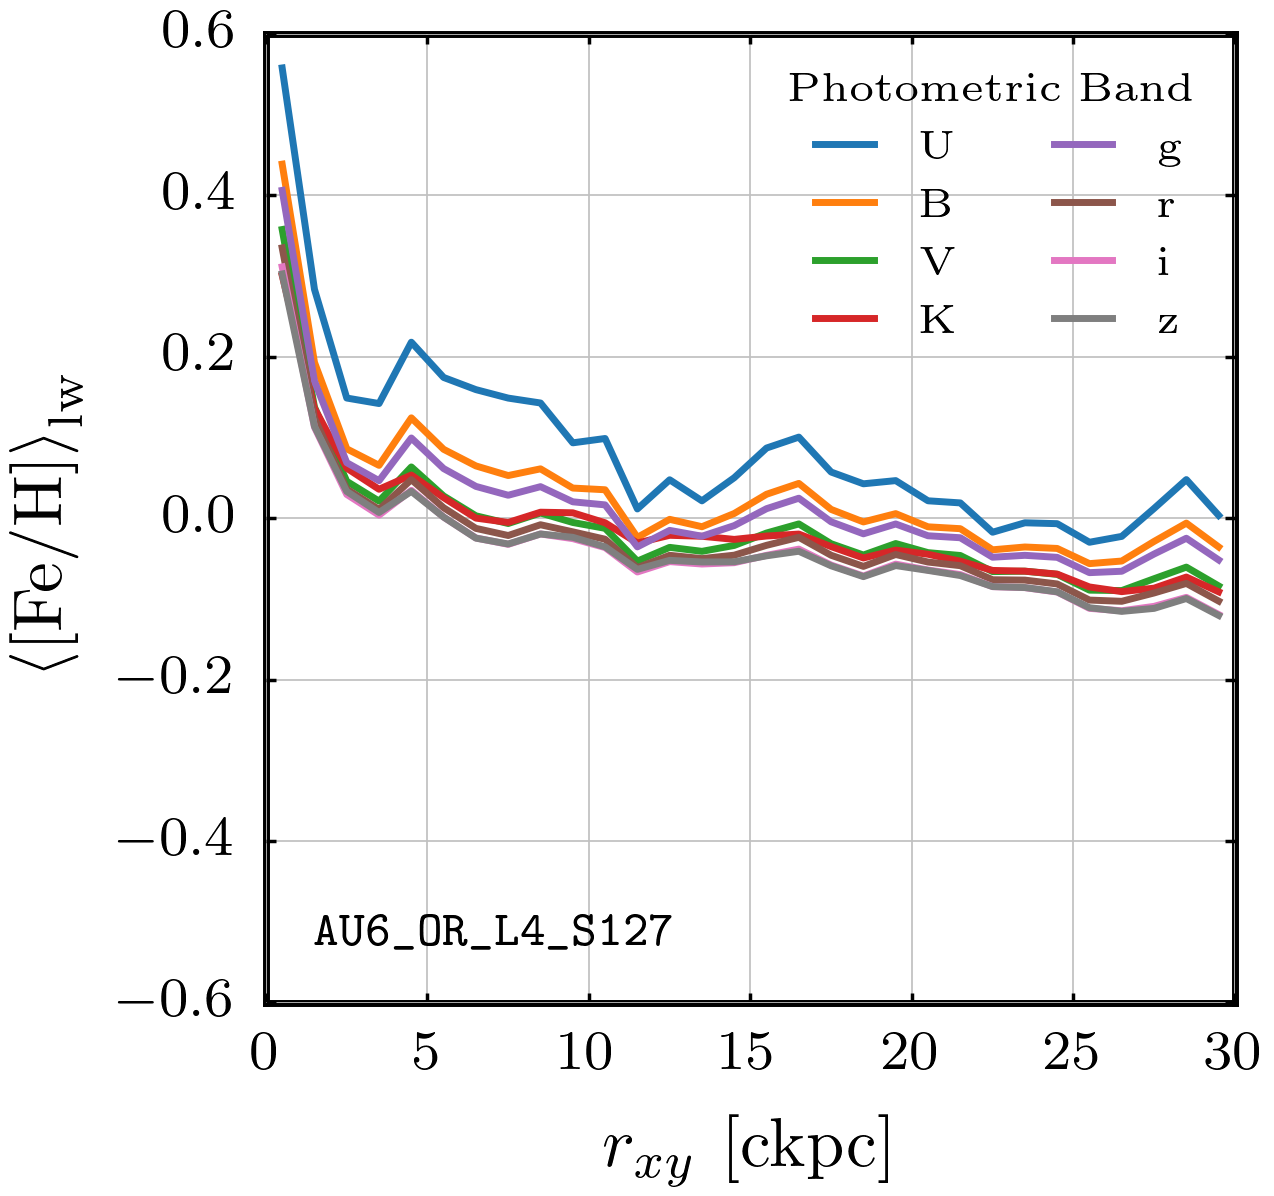

In [113]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.set_xlim(0, 30)
ax.set_ylim(-0.6, 0.6)
ax.set_xlabel(r"$r_{xy}$ [ckpc]")
ax.set_ylabel(r"$\left< \mathrm{[Fe/H]} \right>_\mathrm{lw}$")

ax.grid(True, ls='-', lw=0.25, c='silver')

for band in settings.photometric_bands:
    ax.plot(
        df["BinCenters_ckpc"], df[f"<[Fe/H]>_Band{band}_dex"],
        lw=1.0, zorder=10, ls='-', label=band)

ax.text(
    x=0.05, y=0.05, size=7.0,
    s=r"$\texttt{" + "au6_or_l4_s127".upper() + "}$",
    ha="left", va="bottom", transform=ax.transAxes)

ax.legend(loc="upper right", framealpha=0.0, fontsize=6.0, ncol=2,
          title="Photometric Band", title_fontsize=6.0)

plt.show()

### Au6 - All Bands + Fits

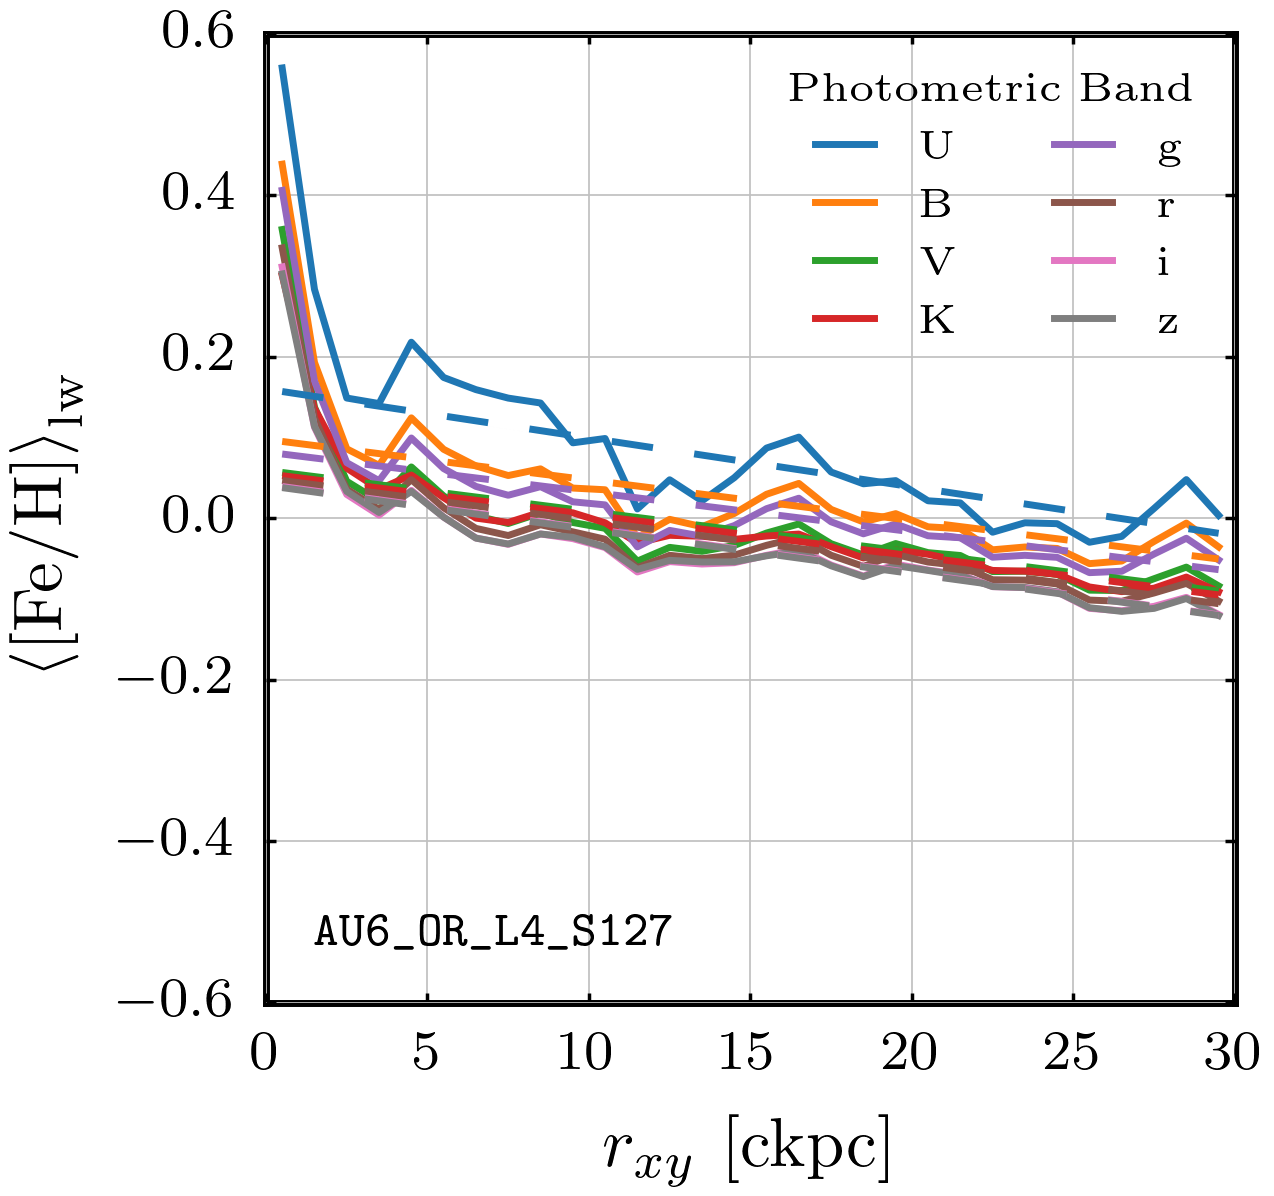

In [114]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.set_xlim(0, 30)
ax.set_ylim(-0.6, 0.6)
ax.set_xlabel(r"$r_{xy}$ [ckpc]")
ax.set_ylabel(r"$\left< \mathrm{[Fe/H]} \right>_\mathrm{lw}$")

ax.grid(True, ls='-', lw=0.25, c='silver')

regressions = []
for i, band in enumerate(settings.photometric_bands):
    x = df["BinCenters_ckpc"].to_numpy()
    y = df[f"<[Fe/H]>_Band{band}_dex"].to_numpy()

    x_range = x[(x >= fit_range[0]) & (x >= fit_range[1])]
    y_range = y[(x >= fit_range[0]) & (x >= fit_range[1])]
    regress = linregress(x=x_range, y=y_range)
    regressions.append(regress)
    ax.plot(x, linear(x, regress.slope, regress.intercept),
        lw=1.0, zorder=10, ls='--',
        color=list(mcolors.TABLEAU_COLORS.values())[i])

    ax.plot(x, y, lw=1.0, zorder=9, ls='-', label=band, 
            color=list(mcolors.TABLEAU_COLORS.values())[i])

ax.text(
    x=0.05, y=0.05, size=7.0,
    s=r"$\texttt{" + "au6_or_l4_s127".upper() + "}$",
    ha="left", va="bottom", transform=ax.transAxes)

ax.legend(loc="upper right", framealpha=0.0, fontsize=6.0, ncol=2,
          title="Photometric Band", title_fontsize=6.0)

plt.show()

### Comparison With Lian+2023 (K-band)

In [115]:
df_exp = pd.read_csv("../data/lian_2023/MW_Z_prof.txt", delimiter=' ')

In [116]:
df = read_sample_data(galaxies=sample, band='K')

In [117]:
df["SampleAverage_<[Fe/H]>_dex"] = df[
    [f"{galaxy.upper()}_<[Fe/H]>_dex" for galaxy in sample]].mean(axis=1)
df["SampleDispersion_<[Fe/H]>_dex"] = df[
    [f"{galaxy.upper()}_<[Fe/H]>_dex" for galaxy in sample]].std(axis=1)

In [118]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.set_xlim(0, 30)
ax.set_ylim(-0.6, 0.6)
ax.set_xlabel(r"$r_{xy}$ [ckpc]")
ax.set_ylabel(r"$\left< \mathrm{[Fe/H]} \right>_\mathrm{lw}$")

ax.grid(True, ls='-', lw=0.25, c='silver')

# Weighted profile for all galaxies
for galaxy in sample:
    ax.plot(df["BinCenters_ckpc"], df[f"{galaxy.upper()}_<[Fe/H]>_dex"],
            lw=0.7, zorder=10, c="gainsboro", ls='-')

ax.plot(df["BinCenters_ckpc"], df[f"AU2_OR_L4_S127_<[Fe/H]>_dex"],
        lw=1, zorder=10, c="tab:green", ls='-',
        label=r"$\texttt{" + "au2_or_l4_s127".upper() + "}$")
ax.plot(df["BinCenters_ckpc"], df[f"AU6_OR_L4_S127_<[Fe/H]>_dex"],
        lw=1, zorder=10, c="tab:blue", ls='-',
        label=r"$\texttt{" + "au6_or_l4_s127".upper() + "}$")
ax.plot(df["BinCenters_ckpc"], df[f"AU11_OR_L4_S127_<[Fe/H]>_dex"],
        lw=1, zorder=10, c="tab:purple", ls='-',
        label=r"$\texttt{" + "au11_or_l4_s127".upper() + "}$")

ax.plot(df["BinCenters_ckpc"], df["SampleAverage_<[Fe/H]>_dex"],
        lw=1, color='k', zorder=11)
ax.plot(df["BinCenters_ckpc"],
        df["SampleAverage_<[Fe/H]>_dex"] - df["SampleDispersion_<[Fe/H]>_dex"],
        lw=1, color='k', zorder=11, ls="--")
ax.plot(df["BinCenters_ckpc"],
        df["SampleAverage_<[Fe/H]>_dex"] + df["SampleDispersion_<[Fe/H]>_dex"],
        lw=1, color='k', zorder=11, ls="--")

# Experimental data
ax.errorbar(df_exp["radius"], df_exp["total"], yerr=df_exp["total_err"],
            fmt="-o", capthick=0, color="tab:red", markersize=2.5,
            markeredgecolor="tab:red", zorder=10, label="Lian et al. (2023)",
            lw=0.7)

ax.legend(loc="upper right", framealpha=0.0, fontsize=6.0)

fig.savefig(f"../images/metallicity_profiles/mw_comparison/profiles.pdf")
plt.close(fig)

In [119]:
dfg = pd.read_csv("../data/grand_2017.csv")
mw_effective_radius_min = 3.4  # kpc
mw_effective_radius_max = 6.7  # kpc
mw_effective_radius_mean = np.mean([
    mw_effective_radius_min, mw_effective_radius_max])

In [120]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.set_xlim(0, 5)
ax.set_ylim(-0.6, 0.6)
ax.set_xlabel(r"$r_{xy}$ [$R_\mathrm{eff}$]")
ax.set_ylabel(r"$\left< \mathrm{[Fe/H]} \right>_\mathrm{lw}$")

ax.grid(True, ls='-', lw=0.25, c='silver')

# Weighted profile for all galaxies
for galaxy in sample:
    dfg_label = galaxy.split('_')[0].capitalize()
    effective_radius = float(
        dfg["RadialScalelength_kpc"][dfg["Run"] == f"{dfg_label}_L4"])
    ax.plot(df["BinCenters_ckpc"] / effective_radius,
            df[f"{galaxy.upper()}_<[Fe/H]>_dex"],
            lw=0.7, zorder=10, c="gainsboro", ls='-')

ax.plot(df["BinCenters_ckpc"] / float(dfg[
        "RadialScalelength_kpc"][dfg["Run"] == "Au2_L4"]),
        df[f"AU2_OR_L4_S127_<[Fe/H]>_dex"],
        lw=1.0, zorder=10, c="tab:green", ls='-',
        label=r"$\texttt{" + f"au2_or_l4_s127".upper() + "}$")
ax.plot(df["BinCenters_ckpc"] / float(dfg[
        "RadialScalelength_kpc"][dfg["Run"] == "Au6_L4"]),
        df[f"AU6_OR_L4_S127_<[Fe/H]>_dex"],
        lw=1.0, zorder=10, c="tab:blue", ls='-',
        label=r"$\texttt{" + f"au6_or_l4_s127".upper() + "}$")
ax.plot(df["BinCenters_ckpc"] / float(dfg[
        "RadialScalelength_kpc"][dfg["Run"] == "Au11_L4"]),
        df[f"AU11_OR_L4_S127_<[Fe/H]>_dex"],
        lw=1.0, zorder=10, c="tab:purple", ls='-',
        label=r"$\texttt{" + f"au6_or_l4_s127".upper() + "}$")

# Experimental data
x1 = df_exp["radius"] / mw_effective_radius_min
x_mean = df_exp["radius"] / mw_effective_radius_mean
x2 = df_exp["radius"] / mw_effective_radius_max
ax.errorbar(x_mean, df_exp["total"],
            yerr=df_exp["total_err"],
            fmt="-o", capthick=0, color="tab:red", markersize=2.5,
            markeredgecolor="tab:red", zorder=10, label="Lian et al. (2023)",
            lw=0.7)
ax.fill_betweenx(y=df_exp["total"].to_numpy()[-9:],
                  x1=x1.to_numpy()[-9:], x2=x2.to_numpy()[-9:],
                  interpolate=True, color="#f3bfbf")
ax.fill_betweenx(y=df_exp["total"], x1=x1, x2=x2,
                 interpolate=True, color="#f3bfbf")

ax.legend(loc="upper right", framealpha=0.0, fontsize=6.0)

fig.savefig(
    f"../images/metallicity_profiles/mw_comparison/profiles_eff_radius.pdf")
plt.close(fig)